In [6]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import sys
%matplotlib inline

sys.path.append("/home/jonas/phd/NanoNets/src/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/NanoNets/src/")

import nanonets

In [7]:
def lorenz(state, sigma=10, rho=28, beta=2.667):

    x, y, z = state
    x_dot   = sigma*(y - x)
    y_dot   = rho*x - y - x*z
    z_dot   = x*y - beta*z

    return [x_dot, y_dot, z_dot]

def rk4_step(func, state, dt, *params):
    """Runge-Kutta 4th order step"""

    k1 = dt * np.array(func(state, *params))
    k2 = dt * np.array(func(state + 0.5 * k1, *params))
    k3 = dt * np.array(func(state + 0.5 * k2, *params))
    k4 = dt * np.array(func(state + k3, *params))

    return state + (k1 + 2 * k2 + 2 * k3 + k4) / 6

#### Genreate Data

In [8]:
# Time Paramter
dt      = 0.01
N_steps = 6000
t       = np.arange(0, N_steps*dt, dt)

# Initial conditions and trajectory
state           = np.array([1.0, 1.0, 1.0])
trajectory      = np.zeros((N_steps,3))
trajectory[0]   = state

# Lorenz system parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

for i in range(1, N_steps):
    state           = rk4_step(lorenz, state, dt, sigma, rho, beta)
    trajectory[i]   = state

start_value = 1000
t           = t[start_value:]
x, y, z     = trajectory[start_value:,0], trajectory[start_value:,1], trajectory[start_value:,2]

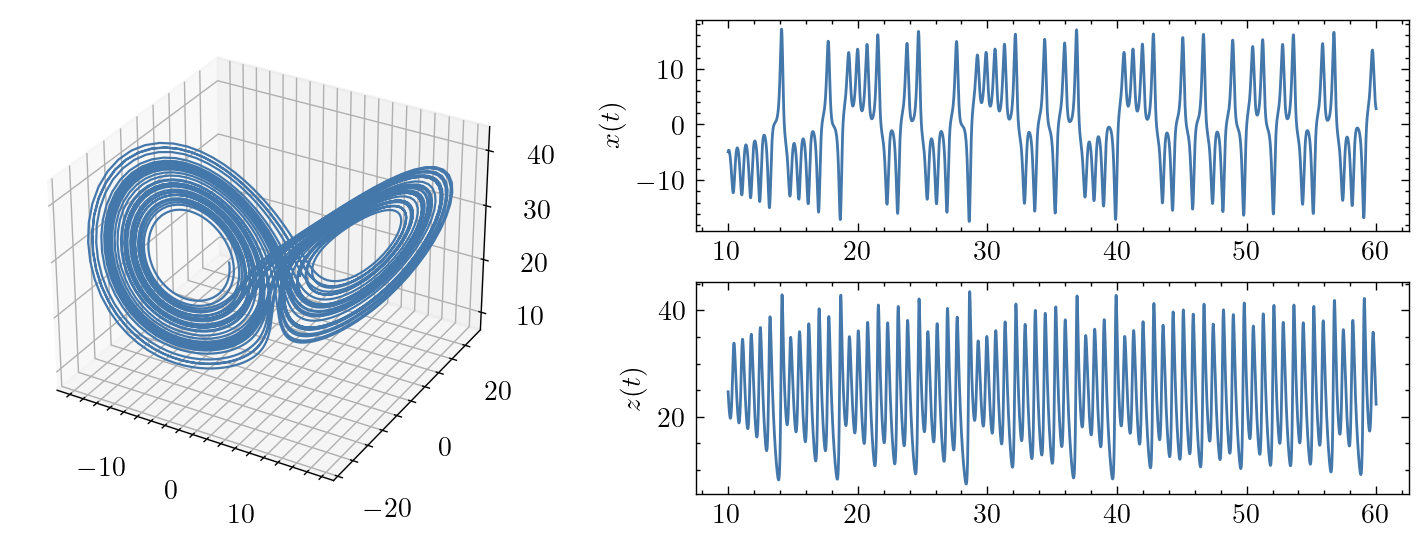

In [9]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200, layout='constrained')
    fig.set_figwidth(fig.get_figwidth()*2.2)

    ax  = fig.add_subplot(1,2,1, projection='3d')
    ax.plot(x, y, z, lw=0.8)
    # ax.set_xlabel('$x(t)$')
    # ax.set_ylabel('$y(t)$')
    # ax.set_zlabel('$z(t)$')

    # ax.grid(False)
    # ax.axis('off')

    ax  = fig.add_subplot(2,2,2)
    ax.plot(t, x)
    ax.set_ylabel('$x(t)$')

    ax  = fig.add_subplot(2,2,4)
    ax.plot(t, z)
    ax.set_ylabel('$z(t)$')
    fig.savefig("lorenz.svg", transparent=True)

In [10]:
np.savetxt(X=x, fname='x_vals.csv')
np.savetxt(X=z, fname='z_vals.csv')

### Test Run

In [11]:
transient_steps     = 4000
stat_size           = 200
eq_steps            = 0

In [12]:
topology_parameter  = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[3,0,0],[0,3,0],[6,0,0],[0,6,0],[6,3,0],[3,6,0],[6,6,0]]
}

max_input   = 0.5
max_control = 0.2
max_output  = 20
x_vals      = np.loadtxt(f"x_vals.csv")
z_vals      = np.loadtxt(f"z_vals.csv")
x_vals      = (x_vals - np.mean(x_vals)) / np.std(x_vals)
z_vals      = (z_vals - np.mean(z_vals)) / np.std(z_vals)
# x_vals      = 2*max_input*(x_vals - np.min(x_vals))/(np.max(x_vals) - np.min(x_vals)) - max_input
# z_vals      = 2*max_output*(z_vals - np.min(z_vals))/(np.max(z_vals) - np.min(z_vals)) - max_output

step_size   = 1e-10
N_voltages  = len(x_vals)
N_controls  = len(topology_parameter["e_pos"]) - 2
time_steps  = step_size*np.arange(N_voltages)

In [13]:
control_voltages    = np.random.uniform(-max_control, max_control, int(N_controls))
voltages            = np.zeros(shape=(N_voltages, len(topology_parameter["e_pos"])+1))
voltages[:,0]       = x_vals
# voltages[:,1:-2]    = np.tile(control_voltages, (N_voltages,1))

In [14]:
target_electrode    = len(topology_parameter["e_pos"]) - 1
    
sim_class           = nanonets.simulation(network_topology='cubic', topology_parameter=topology_parameter)
sim_class.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=target_electrode, eq_steps=eq_steps, stat_size=stat_size, save=False)
output_values       = sim_class.return_output_values()
z_pred              = output_values[:,2]
z_pred              = (z_pred - np.mean(z_pred)) / np.std(z_pred)

KeyError: 'electrode_type'

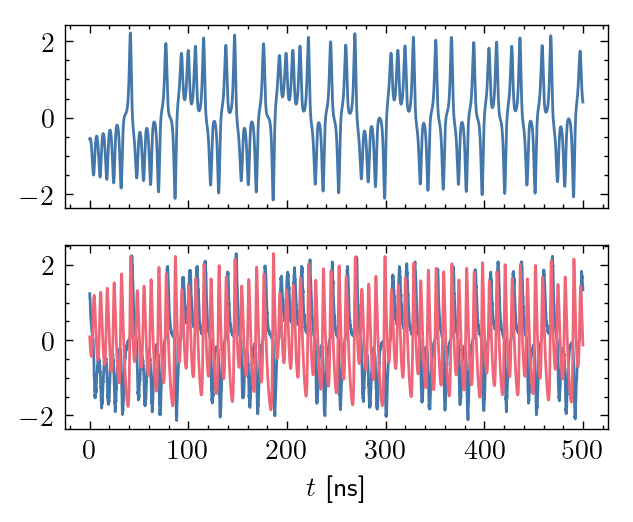

In [ ]:
with plt.style.context(["science","bright"]):

    fig = plt.figure(dpi=200)

    ax  = fig.add_subplot(2,1,1)
    ax.plot(time_steps[1:]*1e9, x_vals[1:])
    ax.set_xticklabels("")

    ax  = fig.add_subplot(2,1,2)
    ax.plot(time_steps[1:]*1e9, z_pred)
    ax.plot(time_steps[1:]*1e9, z_vals[1:])
    ax.set_xlabel("$t$ [ns]")

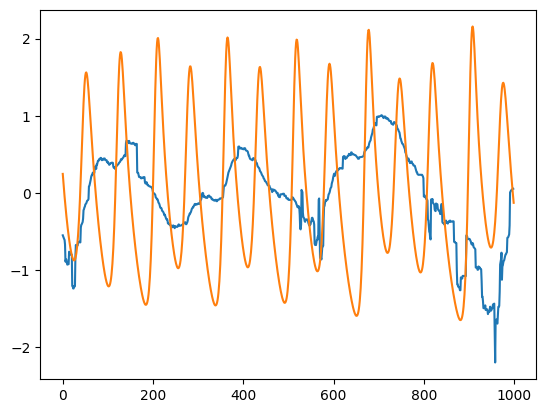

In [17]:
arr = np.loadtxt("data/z_pred_29.csv")
plt.plot(arr[4000:])
plt.plot(z_vals[4000:])